# Crime Rate Prediction — Complete ML Pipeline (Communities & Crime)



In [1]:
# 1) Setup & Imports
import os, json, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

DATA_PATH = Path('data/crimedata.csv')
MODELS_DIR = Path('models'); MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR = Path('reports'); REPORTS_DIR.mkdir(parents=True, exist_ok=True)

TARGET_CANDIDATES = ['ViolentCrimesPerPop','violentcrimesperpop','violentCrimesPerPop']
ID_LIKE_COLS = ['state','county','community','communityname','fold','countyCode','communityCode']

RANDOM_SEED = 42
N_JOBS = -1

MODELS = {
    'ridge': Ridge(alpha=1.0, random_state=RANDOM_SEED),
    'random_forest': RandomForestRegressor(n_estimators=400, random_state=RANDOM_SEED, n_jobs=N_JOBS),
    'gbr': GradientBoostingRegressor(n_estimators=400, learning_rate=0.05, max_depth=3, random_state=RANDOM_SEED),
    'xgb': XGBRegressor(n_estimators=600, max_depth=5, learning_rate=0.05, subsample=0.9,
                        colsample_bytree=0.9, reg_lambda=1.0, random_state=RANDOM_SEED,
                        n_jobs=N_JOBS, tree_method='hist')
}

assert DATA_PATH.exists(), f"CSV not found at {DATA_PATH}. Place crimedata.csv there."
print('Environment ready.')

Environment ready.


## 2) Load Data & Peek

In [3]:
df_raw = pd.read_csv(DATA_PATH, encoding="latin1")
print("Shape:", df_raw.shape)
display(df_raw.head())

Shape: (2215, 147)


,Êcommunityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,...,14,114.85,138,1132.08,16,131.26,2,16.41,41.02,1394.59
1,Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,...,57,242.37,376,1598.78,26,110.55,1,4.25,127.56,1955.95
2,Tigardcity,OR,?,?,1,29344,2.43,0.74,94.33,3.43,...,274,758.14,1797,4972.19,136,376.3,22,60.87,218.59,6167.51
3,Gloversvillecity,NY,35,29443,1,16656,2.40,1.70,97.35,0.50,...,225,1301.78,716,4142.56,47,271.93,?,?,306.64,?
4,Bemidjicity,MN,7,5068,1,11245,2.76,0.53,89.16,1.17,...,91,728.93,1060,8490.87,91,728.93,5,40.05,?,9988.79


## 3) Cleaning

- Strip column whitespace
- Replace `?`, empty strings, `NA`,`na` with `NaN`
- Coerce numeric-like text to numeric
- Drop duplicate rows


In [4]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].replace({'?': np.nan, 'NA': np.nan, 'na': np.nan, '': np.nan})
    for col in df.columns:
        if df[col].dtype == object:
            try:
                df[col] = pd.to_numeric(df[col])
            except Exception:
                pass
    df = df.drop_duplicates()
    return df

df = clean_dataframe(df_raw)
print('After cleaning:', df.shape)

After cleaning: (2215, 147)


### Missingness Overview

In [5]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df))*100
pd.DataFrame({'missing': missing_counts, 'pct': missing_pct}).head(20)

,missing,pct
PctPolicBlack,1872,84.514673
PolicAveOTWorked,1872,84.514673
PolicOperBudg,1872,84.514673
LemasPctPolicOnPatr,1872,84.514673
LemasGangUnitDeploy,1872,84.514673
NumKindsDrugsSeiz,1872,84.514673
PolicBudgPerPop,1872,84.514673
OfficAssgnDrugUnits,1872,84.514673
PctPolicMinor,1872,84.514673
PctPolicAsian,1872,84.514673


## 4) Target & Feature Selection

In [6]:
def guess_target(df: pd.DataFrame) -> str:
    lower = {c.lower(): c for c in df.columns}
    for cand in TARGET_CANDIDATES:
        if cand.lower() in lower:
            return lower[cand.lower()]
    raise ValueError('Target column not found. Expected: ' + ', '.join(TARGET_CANDIDATES))

target_col = guess_target(df)
print('Target:', target_col)

y = df[target_col].astype(float)
X = df.drop(columns=[target_col])

drop_cols = [c for c in X.columns if c.lower() in [d.lower() for d in ID_LIKE_COLS]]
X = X.drop(columns=drop_cols, errors='ignore')

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[num_cols]

nunique = X.nunique()
keep = nunique[nunique > 1].index
X = X[keep]

print('Features used:', len(X.columns))
X.head(3)

Target: ViolentCrimesPerPop
Features used: 141


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,nonViolPerPop
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,...,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,1394.59
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,...,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,1955.95
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,...,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,6167.51


## 5) EDA — Correlation Heatmap (Top‑Variance Subset)

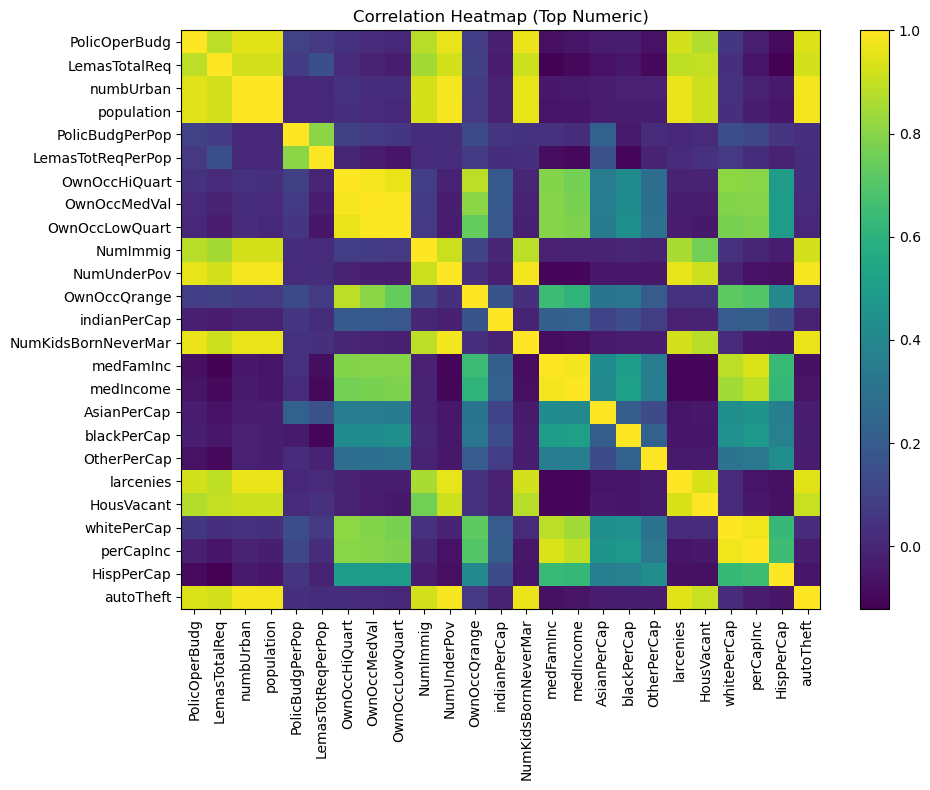

In [7]:
numeric_df = df[X.columns.tolist() + [target_col]].select_dtypes(include=[np.number])
variances = numeric_df.var().sort_values(ascending=False)
top_vars = variances.index[:min(25, len(variances))]
corr = numeric_df[top_vars].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Correlation Heatmap (Top Numeric)')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'eda_correlations.png')
plt.show()

## 6) Train/Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((1772, 141), (443, 141))

## 7) Preprocessing Pipeline (Median Impute + Standard Scale)

In [9]:
numeric_features = X.columns.tolist()

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transform, numeric_features)],
    remainder='drop'
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['population', 'householdsize', 'racepctblack',
                                  'racePctWhite', 'racePctAsian', 'racePctHisp',
                                  'agePct12t21', 'agePct12t29', 'agePct16t24',
                                  'agePct65up', 'numbUrban', 'pctUrban',
                                  'medIncome', 'pctWWage', 'pctWFarmSelf',
                                  'pctWInvInc', 'pctWSocSec', 'pctWPubAsst',
                                  'pctWRetire', 'medFamInc', 'perCapInc',
                                  'whitePerCap', 'blackPerCap', 'indianPerCap',
                                  'AsianPerCap', 'OtherPerCap', 'HispPerCap',
                                  'NumUnderPov', 'PctPopUnderPov',
                                  'PctLess9thGrade', ...])])

## 8) Model Comparison with 5‑Fold CV (RMSE)

CV RMSE — ridge: 1.9989
CV RMSE — random_forest: 94.6433
CV RMSE — gbr: 67.3326
CV RMSE — xgb: 74.5966


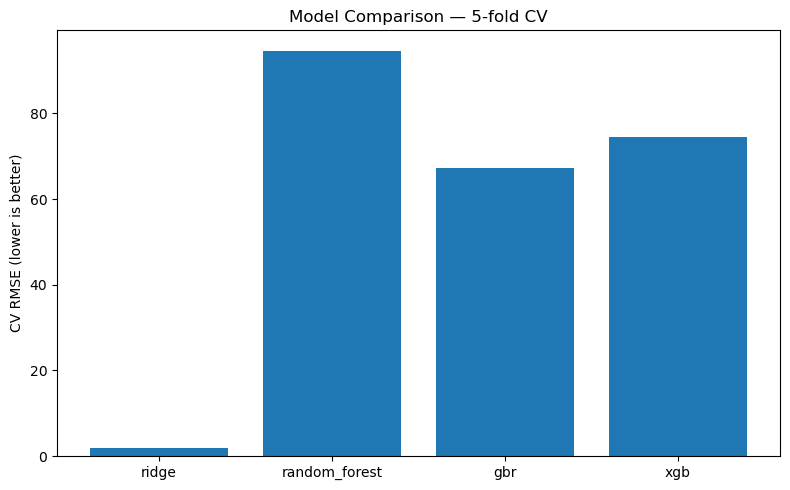

Best by CV: ridge 1.9989275934664241


In [18]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}
best_name, best_rmse = None, 1e9
best_pipe = None

def cv_rmse(pipe, X, y):
    scores = -cross_val_score(pipe, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    return float(np.mean(scores))

for name, model in MODELS.items():
    pipe = Pipeline(steps=[('pre', preprocessor), ('model', model)])
    rmse = cv_rmse(pipe, X_train, y_train)
    results[name] = rmse
    print(f'CV RMSE — {name}: {rmse:.4f}')
    if rmse < best_rmse:
        best_rmse, best_name, best_pipe = rmse, name, pipe

# Bar plot of CV RMSE
plt.figure(figsize=(8,5))
names = list(results.keys()); vals = [results[n] for n in names]
plt.bar(range(len(names)), vals)
plt.xticks(range(len(names)), names)
plt.ylabel('CV RMSE (lower is better)')
plt.title('Model Comparison — 5-fold CV')
plt.tight_layout()
plt.show()

print('Best by CV:', best_name, best_rmse)

In [17]:
# Identify target column
target_col = guess_target(df)
print("Target column:", target_col)

# Check missing target values
missing_t = df[target_col].isna().sum()
print("Missing target values:", missing_t)

# Drop rows with missing target
df_model = df.dropna(subset=[target_col]).copy()
print("After dropping rows with missing target:", df_model.shape)

# Select only numeric columns
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()

# Build X, y
X = df_model[num_cols].drop(columns=[target_col], errors='ignore')
y = df_model[target_col].astype(float)

# Remove rows where all features are NaN
valid_mask = ~X.isna().all(axis=1)
X = X[valid_mask]
y = y[valid_mask]

# Final shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Target column: ViolentCrimesPerPop
Missing target values: 221
After dropping rows with missing target: (1994, 147)
X shape: (1994, 144)
y shape: (1994,)


## 9) Train Best on Train & Evaluate on Hold‑out

In [19]:
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
metrics = {'RMSE': float(rmse), 'MAE': float(mae), 'R2': float(r2)}
metrics

{'RMSE': 1.1815127517458275,
 'MAE': 0.513823439342221,
 'R2': 0.9999959887839758}

### Plots — Actual vs Predicted & Residuals

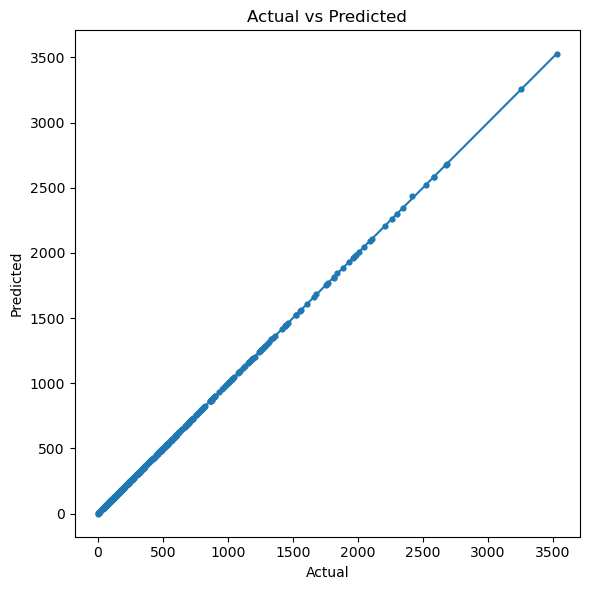

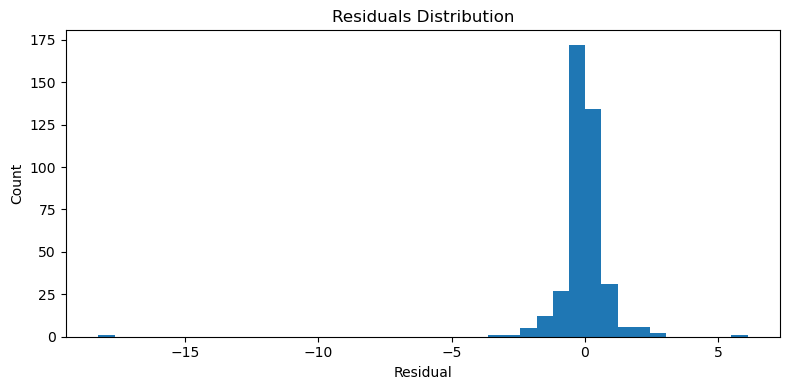

In [23]:
# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=12)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.show()

# Residuals histogram
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=40)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 10) Feature Importance (Tree Models Only)

In [21]:
final_model = best_pipe.named_steps['model']
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    order = np.argsort(importances)[::-1]
    topk = min(25, len(importances))
    plt.figure(figsize=(10,5))
    plt.bar(range(topk), importances[order][:topk])
    labels = np.array(numeric_features)[order][:topk]
    plt.xticks(range(topk), labels, rotation=90)
    plt.title(f'Feature Importance — {type(final_model).__name__}')
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'feature_importance.png')
    plt.show()
else:
    print('Selected model has no native feature_importances_.')

Selected model has no native feature_importances_.


## 11) Save Artifacts (Model + Metadata + Metrics)

In [22]:
import json, joblib
joblib.dump(best_pipe, MODELS_DIR / 'best_model.joblib')
with open(MODELS_DIR / 'feature_meta.json', 'w') as f:
    json.dump({
        'target': target_col,
        'numeric_features': list(X.columns),
        'best_model_name': type(final_model).__name__,
        'cv_rmse': float(best_rmse),
        'holdout': metrics,
        'n_rows': int(len(df)),
        'n_features_used': int(len(X.columns))
    }, f, indent=2)

with open(REPORTS_DIR / 'metrics.txt', 'w') as f:
    for k, v in metrics.items():
        f.write(f"{k}: {v:.5f}\n")

print('Saved: models/best_model.joblib, models/feature_meta.json, reports/metrics.txt')

Saved: models/best_model.joblib, models/feature_meta.json, reports/metrics.txt


In [1]:
# ==========================================
# Research Pipeline: Features & Model Search
# ==========================================
import os, json, warnings, math
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple

# sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance

# xgboost / lightgbm (install lightgbm if available)
from xgboost import XGBRegressor
try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

# -----------------------
# Paths & configuration
# -----------------------
DATA_PATH = Path("data/crimedata.csv")  # your CSV
REPORTS_DIR = Path("reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
N_JOBS = -1
CV = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

TARGET_CANDIDATES = ["ViolentCrimesPerPop","violentcrimesperpop","violentCrimesPerPop"]
ID_LIKE_COLS = [
    "state","county","community","communityname","fold","countyCode","communityCode"
]

# -----------------------
# Utils
# -----------------------
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    # Replace UCI missing markers with NaN
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].replace({"?": np.nan, "NA": np.nan, "na": np.nan, "": np.nan})
    # Try numeric conversion where possible
    for c in df.columns:
        if df[c].dtype == object:
            try:
                df[c] = pd.to_numeric(df[c])
            except Exception:
                pass
    return df

def guess_target(df: pd.DataFrame) -> str:
    lower = {c.lower(): c for c in df.columns}
    for cand in TARGET_CANDIDATES:
        if cand.lower() in lower:
            return lower[cand.lower()]
    raise ValueError(f"Target not found. Expected one of: {TARGET_CANDIDATES}")

def split_Xy(df: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    y = df[target_col].astype(float)
    X = df.drop(columns=[target_col])
    # drop id-like columns
    drop_cols = [c for c in X.columns if c.lower() in [d.lower() for d in ID_LIKE_COLS]]
    X = X.drop(columns=drop_cols, errors="ignore")
    # numeric only
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X = X[num_cols]
    return X, y

def rmse_cv(estimator, X, y, cv=CV, n_jobs=N_JOBS) -> float:
    scores = -cross_val_score(estimator, X, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=n_jobs)
    return float(np.mean(scores))

def save_table(df: pd.DataFrame, name: str):
    path = REPORTS_DIR / name
    df.to_csv(path, index=False)
    print(f"Saved: {path}")

def barh_plot(series: pd.Series, title: str, out_name: str, top=25):
    s = series.sort_values(ascending=True).tail(top)
    plt.figure(figsize=(8, max(4, 0.25*len(s))))
    plt.barh(s.index, s.values)
    plt.title(title)
    plt.tight_layout()
    out = REPORTS_DIR / out_name
    plt.savefig(out, dpi=150)
    plt.close()
    print(f"Saved plot: {out}")

# -----------------------
# Load & prepare data
# -----------------------
# robust CSV read (handles encoding oddities)
try:
    df_raw = pd.read_csv(DATA_PATH)
except UnicodeDecodeError:
    df_raw = pd.read_csv(DATA_PATH, encoding="latin1")
print("Raw shape:", df_raw.shape)

df = clean_dataframe(df_raw)
target_col = guess_target(df)

# Drop rows with missing target
missing_t = df[target_col].isna().sum()
if missing_t > 0:
    print(f"Dropping rows with missing target: {missing_t}")
df = df[~df[target_col].isna()].reset_index(drop=True)

X, y = split_Xy(df, target_col)
print("X shape:", X.shape, " y shape:", y.shape)

# Split for SHAP/permutation efficiency; CV still uses full data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# -----------------------
# Preprocessors
# -----------------------
# Trees don't need scaling; linear/SVM/MLP do
pre_tree = ColumnTransformer(
    transformers=[("num", SimpleImputer(strategy="median"), X.columns)],
    remainder="drop"
)

pre_linear = ColumnTransformer(
    transformers=[("num", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), X.columns)],
    remainder="drop"
)

# ------------------------------------
# EXP-1: Global Feature Importance
# ------------------------------------
# Train RF and XGB on imputed-only data (no scaling)
rf = Pipeline(steps=[("pre", pre_tree),
                    ("model", RandomForestRegressor(
                        n_estimators=500, random_state=RANDOM_SEED, n_jobs=N_JOBS
                    ))])

xgb = Pipeline(steps=[("pre", pre_tree),
                     ("model", XGBRegressor(
                         n_estimators=800, max_depth=6, learning_rate=0.05,
                         subsample=0.9, colsample_bytree=0.9,
                         reg_lambda=1.0, random_state=RANDOM_SEED,
                         n_jobs=N_JOBS, tree_method="hist"
                     ))])

print("\nTraining RF/XGB for global importance...")
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Extract aligned importances (need to map back to original columns)
rf_imp = pd.Series(rf.named_steps["model"].feature_importances_, index=X.columns, name="RF_importance")
xgb_imp = pd.Series(xgb.named_steps["model"].feature_importances_, index=X.columns, name="XGB_importance")

# Permutation importance (on a small sample for speed)
perm_base = Pipeline(steps=[("pre", pre_tree),
                            ("model", XGBRegressor(
                                n_estimators=600, max_depth=5, learning_rate=0.05,
                                subsample=0.9, colsample_bytree=0.9,
                                reg_lambda=1.0, random_state=RANDOM_SEED,
                                n_jobs=N_JOBS, tree_method="hist"
                            ))]).fit(X_train, y_train)

perm_sample = min(800, len(X_test))  # speed cap
perm = permutation_importance(
    perm_base, X_test.iloc[:perm_sample], y_test.iloc[:perm_sample],
    n_repeats=5, random_state=RANDOM_SEED, n_jobs=N_JOBS, scoring="neg_root_mean_squared_error"
)
perm_imp = pd.Series(perm.importances_mean, index=X.columns, name="Permutation_importance").clip(lower=0)

# Try SHAP (optional, skip if not installed)
try:
    import shap
    shap_model = xgb.named_steps["model"]
    explainer = shap.TreeExplainer(shap_model)
    # Use preprocessed input for SHAP: imputed-only matrix
    X_imputed = pre_tree.fit_transform(X_train)
    # sample for speed
    idx = np.random.RandomState(RANDOM_SEED).choice(X_imputed.shape[0], size=min(1000, X_imputed.shape[0]), replace=False)
    shap_values = explainer.shap_values(X_imputed[idx])
    # SHAP per-feature importance = mean(|shap_value|)
    shap_imp_vals = np.abs(shap_values).mean(axis=0)
    shap_imp = pd.Series(shap_imp_vals, index=X.columns, name="SHAP_importance")
    HAS_SHAP = True
except Exception as e:
    print(f"SHAP not available or failed: {e}")
    shap_imp = pd.Series(0, index=X.columns, name="SHAP_importance")
    HAS_SHAP = False

# Combine importance rankings
imp_df = pd.concat([rf_imp, xgb_imp, perm_imp, shap_imp], axis=1).fillna(0.0)

# Rank normalize each column (higher = more important)
rank_df = imp_df.rank(ascending=False, method="average")
avg_rank = rank_df.mean(axis=1).sort_values()  # lower rank number = better
feature_rank_table = pd.DataFrame({
    "avg_rank": avg_rank,
    "RF": rank_df["RF_importance"],
    "XGB": rank_df["XGB_importance"],
    "Permutation": rank_df["Permutation_importance"],
    "SHAP": rank_df["SHAP_importance"] if HAS_SHAP else np.nan
}).sort_values("avg_rank")

save_table(feature_rank_table.reset_index(names="feature"), "feature_global_ranking.csv")
barh_plot(imp_df["XGB_importance"], "XGBoost Feature Importance (Top 25)", "xgb_importance_top25.png", top=25)
barh_plot(imp_df["RF_importance"],  "RandomForest Feature Importance (Top 25)", "rf_importance_top25.png", top=25)
barh_plot(perm_imp,                 "Permutation Importance (Top 25)", "perm_importance_top25.png", top=25)

# ------------------------------------
# EXP-2: Feature Subset Search (Top-k)
# ------------------------------------
top_order = feature_rank_table.index.tolist()  # features sorted by avg_rank ascending
K_LIST = [3,5,7,10,15,20,30,50,"all"]

def subset_cols(k):
    return X.columns if k == "all" else top_order[:k]

def tree_cv_for_subset(cols: List[str]) -> Dict[str,float]:
    # Use impute-only preprocessor for trees
    pre = ColumnTransformer([("num", SimpleImputer(strategy="median"), cols)], remainder="drop")
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=600, random_state=RANDOM_SEED, n_jobs=N_JOBS),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=600, learning_rate=0.05, max_depth=3, random_state=RANDOM_SEED),
        "XGBoost": XGBRegressor(n_estimators=800, max_depth=6, learning_rate=0.05,
                                subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
                                random_state=RANDOM_SEED, n_jobs=N_JOBS, tree_method="hist"),
    }
    out = {}
    for name, mdl in models.items():
        pipe = Pipeline([("pre", pre), ("model", mdl)])
        out[name] = rmse_cv(pipe, X[cols], y)
    return out

subset_rows = []
print("\nRunning feature subset CV...")
for k in K_LIST:
    cols = subset_cols(k)
    scores = tree_cv_for_subset(cols)
    row = {"k": (len(cols) if k!='all' else len(cols))}
    row.update(scores)
    subset_rows.append(row)
subset_df = pd.DataFrame(subset_rows).sort_values("k")
save_table(subset_df, "feature_subset_cv_trees.csv")

# Plot XGB RMSE vs k
plt.figure(figsize=(6,4))
plt.plot(subset_df["k"], subset_df["XGBoost"], marker="o")
plt.xlabel("Number of top features (k)")
plt.ylabel("CV RMSE (lower is better)")
plt.title("XGBoost CV RMSE vs Feature Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(REPORTS_DIR / "xgb_rmse_vs_k.png", dpi=150)
plt.close()

# ------------------------------------
# EXP-3: Model Family Search
# ------------------------------------
# Two settings: (A) all features, (B) top-10 features
top10 = top_order[:10]

def models_for_family():
    models = {
        # Baselines / Linear
        "DummyMean": DummyRegressor(strategy="mean"),
        "Ridge": Ridge(alpha=1.0, random_state=RANDOM_SEED),
        "Lasso": Lasso(alpha=0.0005, random_state=RANDOM_SEED, max_iter=10000),
        "ElasticNet": ElasticNet(alpha=0.0005, l1_ratio=0.2, random_state=RANDOM_SEED, max_iter=10000),

        # Tree Ensembles
        "RandomForest": RandomForestRegressor(n_estimators=700, random_state=RANDOM_SEED, n_jobs=N_JOBS),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=700, learning_rate=0.05, max_depth=3, random_state=RANDOM_SEED),
        "XGBoost": XGBRegressor(n_estimators=900, max_depth=6, learning_rate=0.05,
                                subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
                                random_state=RANDOM_SEED, n_jobs=N_JOBS, tree_method="hist"),
    }
    if HAS_LGBM:
        models["LightGBM"] = LGBMRegressor(
            n_estimators=1200, learning_rate=0.05, num_leaves=31,
            subsample=0.9, colsample_bytree=0.9, random_state=RANDOM_SEED, n_jobs=N_JOBS
        )
    # Nonlinear
    models.update({
        "SVR-RBF": SVR(C=10.0, epsilon=0.05, kernel="rbf"),
        "MLP": MLPRegressor(hidden_layer_sizes=(128,64), activation="relu",
                            alpha=1e-4, learning_rate_init=1e-3,
                            random_state=RANDOM_SEED, max_iter=400)
    })
    return models

def preprocessor_for_model(name: str, cols: List[str]):
    # Linear/SVR/MLP -> impute+scale; Trees -> impute only
    if name in ["Ridge","Lasso","ElasticNet","SVR-RBF","MLP"]:
        return ColumnTransformer([("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), cols)], remainder="drop")
    else:
        return ColumnTransformer([("num", SimpleImputer(strategy="median"), cols)], remainder="drop")

def eval_family(cols: List[str], label: str) -> pd.DataFrame:
    records = []
    models = models_for_family()
    for name, mdl in models.items():
        pre = preprocessor_for_model(name, cols)
        pipe = Pipeline([("pre", pre), ("model", mdl)])
        rmse = rmse_cv(pipe, X[cols], y)
        records.append({"Setting": label, "Model": name, "CV_RMSE": rmse, "k_features": len(cols)})
        print(f"[{label}] {name}: CV RMSE={rmse:.4f}")
    out_df = pd.DataFrame(records).sort_values("CV_RMSE")
    return out_df

print("\nModel family search (ALL features)...")
mf_all = eval_family(list(X.columns), "AllFeatures")
save_table(mf_all, "model_family_cv_all.csv")

print("\nModel family search (TOP-10 features)...")
mf_top10 = eval_family(top10, "Top10Features")
save_table(mf_top10, "model_family_cv_top10.csv")

# Combined plot for quick takeaways
def plot_models(df: pd.DataFrame, title: str, out_name: str):
    df = df.sort_values("CV_RMSE")
    plt.figure(figsize=(8, 5))
    plt.barh(df["Model"], df["CV_RMSE"])
    plt.xlabel("CV RMSE (lower is better)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / out_name, dpi=150)
    plt.close()
    print(f"Saved plot: {REPORTS_DIR / out_name}")

plot_models(mf_all,  "Model Family — All Features",   "models_all_features.png")
plot_models(mf_top10,"Model Family — Top-10 Features","models_top10_features.png")

print("\n=== DONE ===")
print("Artifacts saved into ./reports:")
for p in sorted(REPORTS_DIR.glob("*")):
    print(" -", p.name)


Raw shape: (2215, 147)
Dropping rows with missing target: 221
X shape: (1994, 141)  y shape: (1994,)

Training RF/XGB for global importance...
SHAP not available or failed: No module named 'shap'
Saved: reports\feature_global_ranking.csv
Saved plot: reports\xgb_importance_top25.png
Saved plot: reports\rf_importance_top25.png
Saved plot: reports\perm_importance_top25.png

Running feature subset CV...
Saved: reports\feature_subset_cv_trees.csv

Model family search (ALL features)...
[AllFeatures] DummyMean: CV RMSE=614.1511
[AllFeatures] Ridge: CV RMSE=0.9630
[AllFeatures] Lasso: CV RMSE=3.5151
[AllFeatures] ElasticNet: CV RMSE=0.6179
[AllFeatures] RandomForest: CV RMSE=78.0528
[AllFeatures] GradientBoosting: CV RMSE=48.7419
[AllFeatures] XGBoost: CV RMSE=65.5998
[AllFeatures] SVR-RBF: CV RMSE=481.5669
[AllFeatures] MLP: CV RMSE=59.4386
Saved: reports\model_family_cv_all.csv

Model family search (TOP-10 features)...
[Top10Features] DummyMean: CV RMSE=614.1511
[Top10Features] Ridge: CV RMS

## 12) What to Present

- **Cleaning:** Missing tokens handled; numeric coercion; duplicate removal.  
- **EDA:** Correlation heatmap on top-variance features.  
- **Preprocessing:** Median imputation + StandardScaler in a `ColumnTransformer`.  
- **Modeling:** Ridge / RandomForest / GradientBoosting / XGBoost; **5-fold CV** on train.  
- **Evaluation:** RMSE / MAE / R² on hold-out; Actual vs Predicted; Residuals.  
- **Interpretability:** Tree model feature importance.  
- **Reproducibility:** Saved artifacts for deployment (Streamlit can load these).
